# Library

In [2]:
import sys
sys.path.append('../input/pytorch-image-models/pytorch-image-models-master')

import IPython.display

import os
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
from PIL import Image
from glob import glob
import scipy as sp
import numpy as np
import pandas as pd
#import Pyvips

from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold, train_test_split
from skimage.filters import sobel
from skimage import segmentation
from skimage.color import label2rgb
from skimage.color import rgb2hed, hed2rgb
from skimage.exposure import rescale_intensity
from skimage.measure import regionprops, regionprops_table
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.preprocessing import StandardScaler
from scipy import ndimage as ndi
from matplotlib.patches import Rectangle
from pytorch_lightning.callbacks.early_stopping import EarlyStopping



import torchvision

from tqdm.auto import tqdm
from tqdm import trange
from time import sleep
from functools import partial
import tifffile as tiff

import cv2 as cv
from openslide import OpenSlide
import seaborn as sns
from matplotlib import pyplot as plt
from pprint import pprint

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
import torchvision.transforms as transforms
import torch.optim as optim
import gc
import torchvision.models as models
import copy


OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

from torch.cuda.amp import autocast, GradScaler
Image.MAX_IMAGE_PIXELS = None
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [270]:
#del model_ft
#del model
gc.collect()
print(torch.cuda.max_memory_allocated(device=device))
torch.cuda.empty_cache()


16025031168


# Loading data

In [4]:
transformed_train = pd.read_csv('../input/mayo-clinic-output/new_train.csv')
train, valid = train_test_split(transformed_train, test_size=0.2)
classes_name = ["LAA","CE"]



# Data Loader

In [5]:
class TrainDataset(Dataset):
    def __init__(self, path, df, transform=None):
        self.df = df
        self.path = path
        self.Image_names = df['image_name'].values
        self.labels = df['label'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.Image_names[idx]
        img= Image.open(os.path.join(self.path, f"{file_name}.jpg"))
        if self.transform:
            image=self.transform(img)

        label = self.labels[idx]

        return image, torch.tensor(label), file_name

# Transforms

In [6]:
batch_size=64
data_transform = transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
train_dataset = TrainDataset("../input/mayo-clinic-output/", train, transform = data_transform)
valid_dataset = TrainDataset("../input/mayo-clinic-output/", valid, transform = data_transform)

train_dl = torch.utils.data.DataLoader(train_dataset,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=0)
valid_dl = torch.utils.data.DataLoader(valid_dataset,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=0)

In [7]:
def imshow(axis, inp):
    """Denormalize and show"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    axis.imshow(inp)


In [8]:
"""img, label = next(iter(train_dl))
print(img.size(), label.size())
fig = plt.figure(1, figsize=(16, 4))
grid = ImageGrid(fig, 111, nrows_ncols=(8, 10), axes_pad=0.05)    
for i in range(img.size()[0]):
    ax = grid[i]
    imshow(ax, img[i])
"""

'img, label = next(iter(train_dl))\nprint(img.size(), label.size())\nfig = plt.figure(1, figsize=(16, 4))\ngrid = ImageGrid(fig, 111, nrows_ncols=(8, 10), axes_pad=0.05)    \nfor i in range(img.size()[0]):\n    ax = grid[i]\n    imshow(ax, img[i])\n'

# PreTrained Model

In [9]:
use_gpu = torch.cuda.is_available()
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft=model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)



Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

# Training

In [10]:
def train_model(dataloders, model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    use_gpu = torch.cuda.is_available()
    best_model_wts = model.state_dict()
    best_acc = 0.0
    dataset_sizes = {'train': len(dataloders['train'].dataset), 
                     'valid': len(dataloders['valid'].dataset)}

    for epoch in range(num_epochs):
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train(True)
            else:
                model.train(False)

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels, _ in dataloders[phase]:
                if use_gpu:
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                else:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                optimizer.zero_grad()

                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                running_loss += loss.data
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                train_epoch_loss = running_loss / dataset_sizes[phase]
                train_epoch_acc = running_corrects / dataset_sizes[phase]
            else:
                valid_epoch_loss = running_loss / dataset_sizes[phase]
                valid_epoch_acc = running_corrects / dataset_sizes[phase]
                
            if phase == 'valid' and valid_epoch_acc > best_acc:
                best_acc = valid_epoch_acc
                best_model_wts = model.state_dict()

        print('Epoch [{}/{}] train loss: {:.4f} acc: {:.4f} ' 
              'valid loss: {:.4f} acc: {:.4f}'.format(
                epoch, num_epochs - 1,
                train_epoch_loss, train_epoch_acc, 
                valid_epoch_loss, valid_epoch_acc))
            
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

In [11]:
dloaders = {'train':train_dl, 'valid':valid_dl}
start_time = time.time()
model = train_model(dloaders, model_ft, criterion, optimizer, exp_lr_scheduler, num_epochs=12)
print('Training time: {:10f} minutes'.format((time.time()-start_time)/60))

Epoch [0/11] train loss: 0.0109 acc: 0.6558 valid loss: 0.0105 acc: 0.6540
Epoch [1/11] train loss: 0.0103 acc: 0.7032 valid loss: 0.0184 acc: 0.3886
Epoch [2/11] train loss: 0.0079 acc: 0.7648 valid loss: 0.0090 acc: 0.7137
Epoch [3/11] train loss: 0.0059 acc: 0.8333 valid loss: 0.0109 acc: 0.6891
Epoch [4/11] train loss: 0.0040 acc: 0.9026 valid loss: 0.0119 acc: 0.7261
Epoch [5/11] train loss: 0.0051 acc: 0.8817 valid loss: 0.0259 acc: 0.6976
Epoch [6/11] train loss: 0.0029 acc: 0.9251 valid loss: 0.0094 acc: 0.7678
Epoch [7/11] train loss: 0.0009 acc: 0.9874 valid loss: 0.0105 acc: 0.7687
Epoch [8/11] train loss: 0.0005 acc: 0.9957 valid loss: 0.0108 acc: 0.7782
Epoch [9/11] train loss: 0.0003 acc: 0.9986 valid loss: 0.0122 acc: 0.7773
Epoch [10/11] train loss: 0.0002 acc: 0.9993 valid loss: 0.0124 acc: 0.7791
Epoch [11/11] train loss: 0.0001 acc: 0.9993 valid loss: 0.0130 acc: 0.7829
Best val Acc: 0.782938
Training time:   7.513071 minutes


In [12]:
def visualize_model(dataloders, model, num_images=25):
    cnt = 0
    fig = plt.figure(1, figsize=(20, 20))
    grid = ImageGrid(fig, 111, nrows_ncols=(5, 5), axes_pad=0.05)
    for i, (inputs, labels, file_name) in enumerate(dataloders['valid']):
        if use_gpu:
            inputs = inputs.to(device)
            labels = labels.to(device)
        else:
            inputs = inputs.to(device)
            labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        sm = torch.nn.Softmax()
        probabilities = sm(outputs).tolist()
        rounded_prob = [np.round(num, 1) for num in probabilities]
        for j in range(inputs.size()[0]):
            ax = grid[cnt]
            imshow(ax, inputs.cpu().data[j])
            ax.text(10, 20, 'ID: {} '.format(file_name[j]),color='k', backgroundcolor='w', alpha=0.8,size="small")
            ax.text(10, 230, 'Predicted {} || Actual {}'.format(classes_name[preds[j]], classes_name[labels.data[j]]), 
                    color='k', backgroundcolor='w', alpha=0.8,size="small")
            ax.text(10, 245,rounded_prob[j],color='k', backgroundcolor='w', alpha=0.8,size="small")
            cnt += 1
            if cnt == num_images:
                return

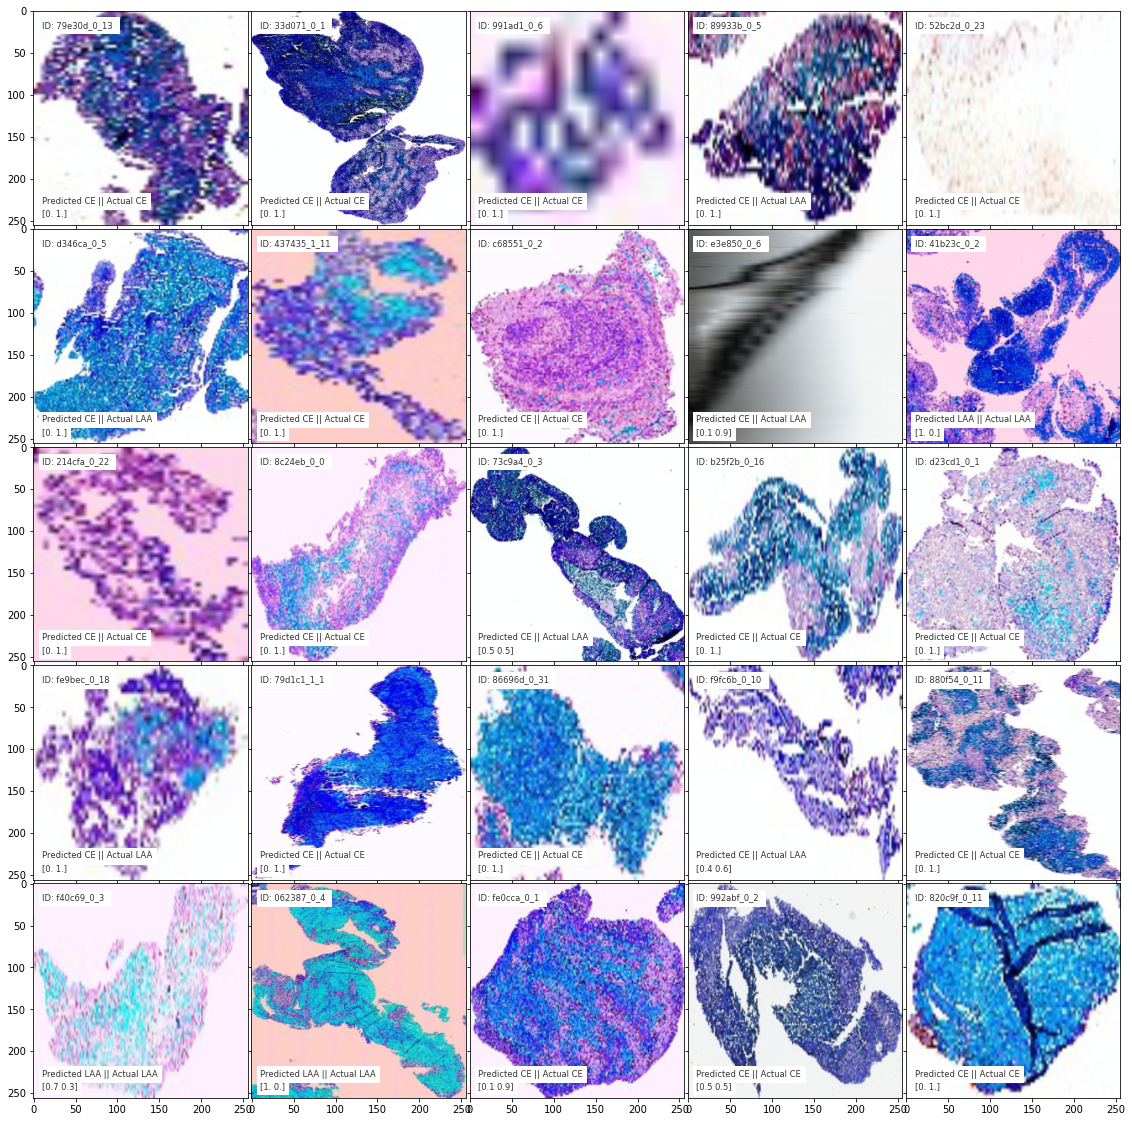

In [13]:
visualize_model(dloaders, model)


In [388]:
def submission(dataloders, model):
    prob_data = {"ID":[],"prob":[]}
    for i, (inputs, labels, file_name) in enumerate(dataloders['valid']):
        if use_gpu:
            inputs = inputs.to(device)
            labels = labels.to(device)
        else:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        sm = torch.nn.Softmax()
        probabilities = sm(outputs).tolist()
        rounded_prob = [np.round(num, 1) for num in probabilities]
        for i in range(inputs.size()[0]):
            prob_data["ID"].append(file_name[i])
            prob_data["prob"].append(rounded_prob[i])
    prob_data= pd.DataFrame.from_dict(prob_data)
    prob_data['patient_id'], prob_data['image_nu'],prob_data['split_nu'] = prob_data['ID'].str.split('_').str
    prob_data[['LAA','CE']] = pd.DataFrame(prob_data.prob.tolist(), index= prob_data.index)
    prob_data_submission = prob_data.drop(['ID', 'prob','image_nu','split_nu'], axis=1)
    avg = prob_data_submission.groupby('patient_id',as_index=False).mean()
    avg = avg[['patient_id','CE','LAA']]
    
    return avg
    

In [389]:
avg=submission(dloaders, model)


  patient_id   LAA    CE
0     006388  0.00  1.00
1     00c058  0.35  0.65
2     01adc5  0.10  0.90
3     026c97  0.30  0.70
4     028989  0.60  0.40


In [391]:
avg.to_csv('submission.csv',index=False)


In [365]:
print(prob_data.head())


NameError: name 'prob_data' is not defined